### Insurance Fraud Detection

Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")


import os
import re
import json
from datetime import datetime
from datetime import date

#dataframe manipulation
import numpy as np
import pandas as pd

#visualisations
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats
import seaborn as sns
import matplotlib.dates as mdates
plt.style.use('bmh')
from sklearn.metrics import mean_squared_error

#time series data
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

#### Import file

In [2]:
df = pd.read_excel("Data.xlsx", sheet_name="Sheet1")
df.head(4)

,AccidentArea,Sex,Age,Fault,VehicleCategory,BasePolicy,PastNumberOfClaims,PoliceReportFiled,WitnessPresent,GDP,DelayInReporting,FraudFound_P
0,Urban,Female,21,Policy Holder,Sport,Liability,none,No,No,7455.288,31.0,0
1,Urban,Male,34,Policy Holder,Sport,Collision,none,Yes,No,7115.652,0.0,0
2,Urban,Male,47,Policy Holder,Sport,Collision,1,No,No,7455.288,31.0,0
3,Rural,Male,65,Third Party,Sport,Liability,1,Yes,No,7246.931,30.0,0


#### Exploratory Descriptive Analysis

In [3]:
df.shape

(15420, 12)

There are 33 columns in total with 15420 cases in the dataset

In [4]:
#Confirm datatypes
df.dtypes

AccidentArea           object
Sex                    object
Age                     int64
Fault                  object
VehicleCategory        object
BasePolicy             object
PastNumberOfClaims     object
PoliceReportFiled      object
WitnessPresent         object
GDP                   float64
DelayInReporting      float64
FraudFound_P            int64
dtype: object

In [5]:
df['FraudFound_P'] = df['FraudFound_P'].astype(str)
df['GDP'] = df['GDP'].astype(int)
#df['DelayInReporting'] = df['DelayInReporting'].astype(int)

#### Create dummy variables

In [ ]:
AccidentArea           object
Sex                    object
Age                     int64
Fault                  object
PolicyType             object
VehicleCategory        object
PastNumberOfClaims     object
PoliceReportFiled      object
WitnessPresent         object
GDP                   float64
FraudFound_P            int6

In [6]:

cat_vars=['AccidentArea', 'Sex', 'Fault', 'PolicyType', 'VehicleCategory', 'PastNumberOfClaims', 'PoliceReportFiled', 'WitnessPresent']

for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df[var], prefix=var)
    df1=df.join(cat_list)
    df=df1

cat_vars=['AccidentArea', 'Sex', 'Fault', 'PolicyType', 'VehicleCategory', 'PastNumberOfClaims', 'PoliceReportFiled', 'WitnessPresent']
df_vars=df.columns.values.tolist()
to_keep=[i for i in df_vars if i not in cat_vars]

KeyError: 'PolicyType'

In [7]:
df=df[to_keep]
df.columns.values

array(['Age', 'GDP', 'FraudFound_P', 'AccidentArea_Rural',
       'AccidentArea_Urban', 'Sex_Female', 'Sex_Male',
       'Fault_Policy Holder', 'Fault_Third Party',
       'PolicyType_Sedan - All Perils', 'PolicyType_Sedan - Collision',
       'PolicyType_Sedan - Liability', 'PolicyType_Sport - All Perils',
       'PolicyType_Sport - Collision', 'PolicyType_Sport - Liability',
       'PolicyType_Utility - All Perils',
       'PolicyType_Utility - Collision', 'PolicyType_Utility - Liability',
       'VehicleCategory_Sedan', 'VehicleCategory_Sport',
       'VehicleCategory_Utility', 'PastNumberOfClaims_1',
       'PastNumberOfClaims_2 to 4', 'PastNumberOfClaims_more than 4',
       'PastNumberOfClaims_none', 'PoliceReportFiled_No',
       'PoliceReportFiled_Yes', 'WitnessPresent_No', 'WitnessPresent_Yes'],
      dtype=object)

In [8]:
df.shape

(15420, 29)

In [10]:
df.head(10)

,Age,GDP,FraudFound_P,AccidentArea_Rural,AccidentArea_Urban,Sex_Female,Sex_Male,Fault_Policy Holder,Fault_Third Party,PolicyType_Sedan - All Perils,...,VehicleCategory_Sport,VehicleCategory_Utility,PastNumberOfClaims_1,PastNumberOfClaims_2 to 4,PastNumberOfClaims_more than 4,PastNumberOfClaims_none,PoliceReportFiled_No,PoliceReportFiled_Yes,WitnessPresent_No,WitnessPresent_Yes
0,21,7455.288,0,0,1,1,0,1,0,0,...,1,0,0,0,0,1,1,0,1,0
1,34,7115.652,0,0,1,0,1,1,0,0,...,1,0,0,0,0,1,0,1,1,0
2,47,7455.288,0,0,1,0,1,1,0,0,...,1,0,1,0,0,0,1,0,1,0
3,65,7246.931,0,1,0,0,1,0,1,0,...,1,0,1,0,0,0,0,1,1,0
4,27,7115.652,0,0,1,1,0,0,1,0,...,1,0,0,0,0,1,1,0,1,0
5,20,7455.288,0,0,1,0,1,0,1,0,...,1,0,0,0,0,1,1,0,1,0
6,36,7115.652,0,0,1,0,1,0,1,0,...,1,0,1,0,0,0,1,0,1,0
7,0,7455.288,0,0,1,0,1,1,0,0,...,1,0,1,0,0,0,1,0,1,0
8,30,7455.288,0,0,1,0,1,1,0,0,...,1,0,0,0,0,1,1,0,0,1
9,42,7246.931,0,0,1,0,1,1,0,0,...,0,1,0,1,0,0,1,0,1,0


In [7]:
#move target variable back to the end of dataset|
df = df.reindex(columns = [col for col in df.columns if col != 'FraudFound_P'] + ['FraudFound_P'])
df

,AccidentArea,Sex,Age,Fault,VehicleCategory,BasePolicy,PastNumberOfClaims,PoliceReportFiled,WitnessPresent,GDP,FraudFound_P
0,Urban,Female,21,Policy Holder,Sport,Liability,none,No,No,7455,0
1,Urban,Male,34,Policy Holder,Sport,Collision,none,Yes,No,7115,0
2,Urban,Male,47,Policy Holder,Sport,Collision,1,No,No,7455,0
3,Rural,Male,65,Third Party,Sport,Liability,1,Yes,No,7246,0
4,Urban,Female,27,Third Party,Sport,Collision,none,No,No,7115,0
...,...,...,...,...,...,...,...,...,...,...,...
15415,Urban,Male,35,Policy Holder,Sedan,Collision,2 to 4,No,No,8259,1
15416,Urban,Male,30,Policy Holder,Sport,Liability,more than 4,No,No,8259,0
15417,Rural,Male,24,Policy Holder,Sedan,Collision,more than 4,No,No,8259,1
15418,Urban,Female,34,Third Party,Sedan,All Perils,none,No,No,8259,0


In [9]:
#matrix = df.corr()
#matrix.to_excel("Correlation_Matrix.xlsx")

<AxesSubplot:>

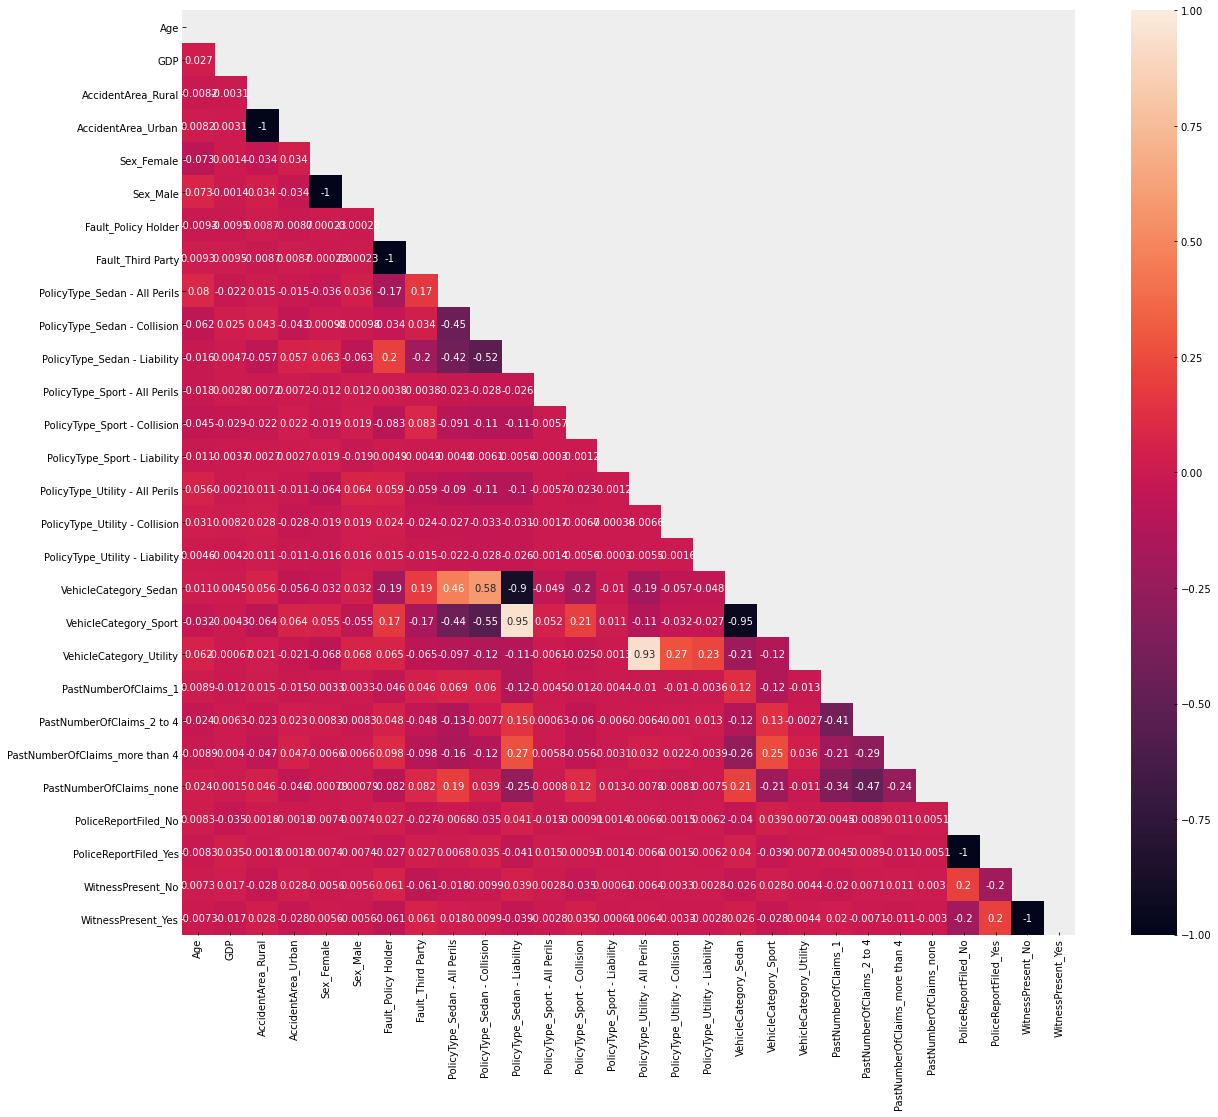

In [13]:
# set figure size
plt.figure(figsize=(20,17))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# generate heatmap
sns.heatmap(df.corr(method='pearson'), annot=True, mask=mask, vmin=-1, vmax=1)

In [6]:
#Due to the dummy variable trap remove first dummy variable for each variable
cat_vars=['AccidentArea', 'Sex', 'Fault', 'BasePolicy', 'VehicleCategory', 'PastNumberOfClaims', 'PoliceReportFiled', 'WitnessPresent']

for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df[var], prefix=var, drop_first=True)
    df1=df.join(cat_list)
    df=df1

cat_vars=['AccidentArea', 'Sex', 'Fault', 'BasePolicy', 'VehicleCategory', 'PastNumberOfClaims', 'PoliceReportFiled', 'WitnessPresent']
df_vars=df.columns.values.tolist()
to_keep=[i for i in df_vars if i not in cat_vars]

In [7]:
df=df[to_keep]
df.columns.values

array(['Age', 'GDP', 'DelayInReporting', 'FraudFound_P',
       'AccidentArea_Urban', 'Sex_Male', 'Fault_Third Party',
       'BasePolicy_Collision', 'BasePolicy_Liability',
       'VehicleCategory_Sport', 'VehicleCategory_Utility',
       'PastNumberOfClaims_2 to 4', 'PastNumberOfClaims_more than 4',
       'PastNumberOfClaims_none', 'PoliceReportFiled_Yes',
       'WitnessPresent_Yes'], dtype=object)

In [8]:
#move target variable back to the end of dataset|
df = df.reindex(columns = [col for col in df.columns if col != 'FraudFound_P'] + ['FraudFound_P'])
df

,Age,GDP,DelayInReporting,AccidentArea_Urban,Sex_Male,Fault_Third Party,BasePolicy_Collision,BasePolicy_Liability,VehicleCategory_Sport,VehicleCategory_Utility,PastNumberOfClaims_2 to 4,PastNumberOfClaims_more than 4,PastNumberOfClaims_none,PoliceReportFiled_Yes,WitnessPresent_Yes,FraudFound_P
0,21,7455,31.0,1,0,0,0,1,1,0,0,0,1,0,0,0
1,34,7115,0.0,1,1,0,1,0,1,0,0,0,1,1,0,0
2,47,7455,31.0,1,1,0,1,0,1,0,0,0,0,0,0,0
3,65,7246,30.0,0,1,1,0,1,1,0,0,0,0,1,0,0
4,27,7115,31.0,1,0,1,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,35,8259,0.0,1,1,0,1,0,0,0,1,0,0,0,0,1
15416,30,8259,30.0,1,1,0,0,1,1,0,0,1,0,0,0,0
15417,24,8259,30.0,0,1,0,1,0,0,0,0,1,0,0,0,1
15418,34,8259,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0


In [9]:
df.head(10)

,Age,GDP,DelayInReporting,AccidentArea_Urban,Sex_Male,Fault_Third Party,BasePolicy_Collision,BasePolicy_Liability,VehicleCategory_Sport,VehicleCategory_Utility,PastNumberOfClaims_2 to 4,PastNumberOfClaims_more than 4,PastNumberOfClaims_none,PoliceReportFiled_Yes,WitnessPresent_Yes,FraudFound_P
0,21,7455,31.0,1,0,0,0,1,1,0,0,0,1,0,0,0
1,34,7115,0.0,1,1,0,1,0,1,0,0,0,1,1,0,0
2,47,7455,31.0,1,1,0,1,0,1,0,0,0,0,0,0,0
3,65,7246,30.0,0,1,1,0,1,1,0,0,0,0,1,0,0
4,27,7115,31.0,1,0,1,1,0,1,0,0,0,1,0,0,0
5,20,7455,31.0,1,1,1,1,0,1,0,0,0,1,0,0,0
6,36,7115,0.0,1,1,1,1,0,1,0,0,0,0,0,0,0
7,0,7455,120.0,1,1,0,1,0,1,0,0,0,0,0,0,0
8,30,7455,0.0,1,1,0,1,0,1,0,0,0,1,0,1,0
9,42,7246,0.0,1,1,0,0,0,0,1,1,0,0,0,0,0


<AxesSubplot:>

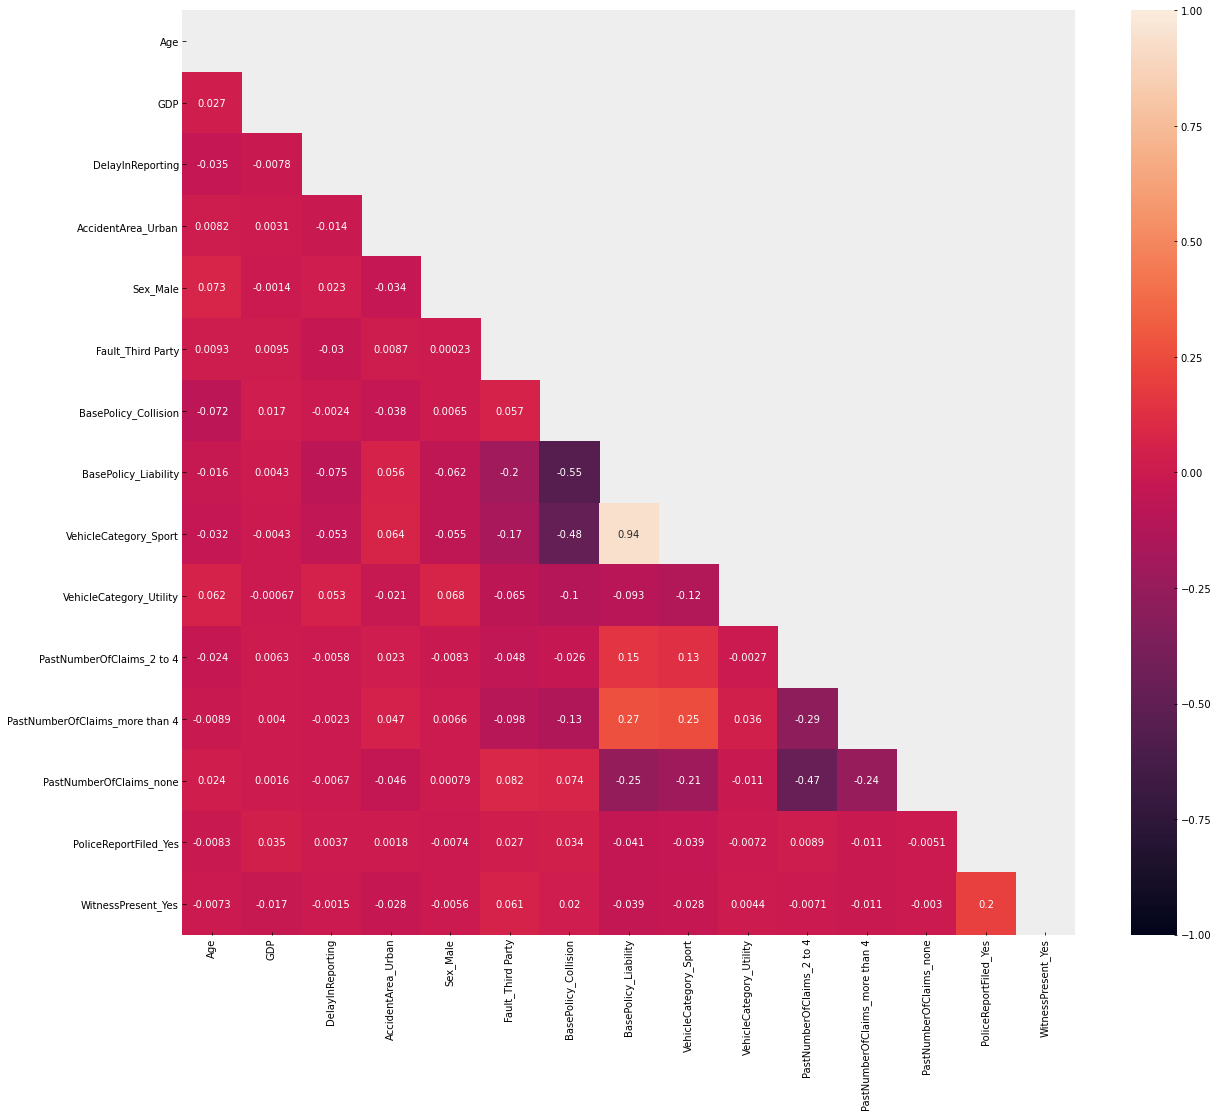

In [10]:
# set figure size
plt.figure(figsize=(20,17))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# generate heatmap
sns.heatmap(df.corr(method='pearson'), annot=True, mask=mask, vmin=-1, vmax=1)

In [11]:
df.head(6)

,Age,GDP,DelayInReporting,AccidentArea_Urban,Sex_Male,Fault_Third Party,BasePolicy_Collision,BasePolicy_Liability,VehicleCategory_Sport,VehicleCategory_Utility,PastNumberOfClaims_2 to 4,PastNumberOfClaims_more than 4,PastNumberOfClaims_none,PoliceReportFiled_Yes,WitnessPresent_Yes,FraudFound_P
0,21,7455,31.0,1,0,0,0,1,1,0,0,0,1,0,0,0
1,34,7115,0.0,1,1,0,1,0,1,0,0,0,1,1,0,0
2,47,7455,31.0,1,1,0,1,0,1,0,0,0,0,0,0,0
3,65,7246,30.0,0,1,1,0,1,1,0,0,0,0,1,0,0
4,27,7115,31.0,1,0,1,1,0,1,0,0,0,1,0,0,0
5,20,7455,31.0,1,1,1,1,0,1,0,0,0,1,0,0,0


Random Sampling

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.3, random_state=7, shuffle=False)
print(f"{train_set.shape[0]} train instances and {test_set.shape[0]} test instances")

10794 train instances and 4626 test instances


Stratified Sampling

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=7)
train_index, test_index = list(stratified_splitter.split(df, df['FraudFound_P']))[0]
strat_train_set = df.loc[train_index]
strat_test_set = df.loc[test_index]

Random vs Stratified Sampling

In [14]:
def fraud_proportions(df):
    return df['FraudFound_P'].value_counts() / len(df)

rand_train_set, rand_test_set = train_test_split(df, test_size=0.2, random_state=7)

df_tmp = pd.DataFrame({
    "Overall": fraud_proportions(df),
    "Random test set": fraud_proportions(rand_test_set),
    "Stratified test set": fraud_proportions(strat_test_set)
}).sort_index()

df_tmp["Ran. %error"] = 100 * df_tmp["Random test set"] / df_tmp["Overall"] - 100
df_tmp["Strat. %error"] = 100 * df_tmp["Stratified test set"] / df_tmp["Overall"] - 100

df_tmp

,Overall,Random test set,Stratified test set,Ran. %error,Strat. %error
0,0.940143,0.94358,0.940121,0.365593,-0.002299
1,0.059857,0.05642,0.059879,-5.742145,0.036114


stratified sampling is more representative of the dataset. Under-representations of the fraud found P = -5.743% for random sampling, fraudfound_Yes is oversampled by 0.02%

In [15]:
trainset =  strat_train_set
testset =  strat_test_set

In [16]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10794 entries, 1267 to 7619
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             10794 non-null  int64  
 1   GDP                             10794 non-null  int64  
 2   DelayInReporting                10794 non-null  float64
 3   AccidentArea_Urban              10794 non-null  uint8  
 4   Sex_Male                        10794 non-null  uint8  
 5   Fault_Third Party               10794 non-null  uint8  
 6   BasePolicy_Collision            10794 non-null  uint8  
 7   BasePolicy_Liability            10794 non-null  uint8  
 8   VehicleCategory_Sport           10794 non-null  uint8  
 9   VehicleCategory_Utility         10794 non-null  uint8  
 10  PastNumberOfClaims_2 to 4       10794 non-null  uint8  
 11  PastNumberOfClaims_more than 4  10794 non-null  uint8  
 12  PastNumberOfClaims_none       

In [17]:
minvalue = trainset['Age'].min()
minvalue

0

In [10]:
#replace 0 in Age with nan
df['Age'] = df['Age'].replace(0, np.nan)

In [18]:
#replace 0 in Age with nan
trainset['Age'] = trainset['Age'].replace(0, np.nan)

In [19]:
trainset.isnull().sum()

Age                               216
GDP                                 0
DelayInReporting                    0
AccidentArea_Urban                  0
Sex_Male                            0
Fault_Third Party                   0
BasePolicy_Collision                0
BasePolicy_Liability                0
VehicleCategory_Sport               0
VehicleCategory_Utility             0
PastNumberOfClaims_2 to 4           0
PastNumberOfClaims_more than 4      0
PastNumberOfClaims_none             0
PoliceReportFiled_Yes               0
WitnessPresent_Yes                  0
FraudFound_P                        0
dtype: int64

There are 216 missing values in the training set for age

In [11]:
#Replace missing values with mean
import numpy as np
from sklearn.impute import SimpleImputer
imp =  SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df)

SimpleImputer()

In [12]:
transformed = imp.transform(df)

In [13]:
df = pd.DataFrame(transformed, columns=df.columns)
df.isnull().sum()

Age                               0
GDP                               0
DelayInReporting                  0
AccidentArea_Urban                0
Sex_Male                          0
Fault_Third Party                 0
BasePolicy_Collision              0
BasePolicy_Liability              0
VehicleCategory_Sport             0
VehicleCategory_Utility           0
PastNumberOfClaims_2 to 4         0
PastNumberOfClaims_more than 4    0
PastNumberOfClaims_none           0
PoliceReportFiled_Yes             0
WitnessPresent_Yes                0
FraudFound_P                      0
dtype: int64

In [23]:
#resolved the missing values in the Age column

Check for missing values in the testset

In [24]:
minvalue = testset['Age'].min()
minvalue

0

In [25]:
#replace 0 in Age with nan
testset['Age'] = testset['Age'].replace(0, np.nan)

In [14]:
df.isna().sum()

Age                               0
GDP                               0
DelayInReporting                  0
AccidentArea_Urban                0
Sex_Male                          0
Fault_Third Party                 0
BasePolicy_Collision              0
BasePolicy_Liability              0
VehicleCategory_Sport             0
VehicleCategory_Utility           0
PastNumberOfClaims_2 to 4         0
PastNumberOfClaims_more than 4    0
PastNumberOfClaims_none           0
PoliceReportFiled_Yes             0
WitnessPresent_Yes                0
FraudFound_P                      0
dtype: int64

In [27]:
#One missing value in the DelayInReporting - mean
#104 missing values in the Age column - mean imputation

In [28]:
#Replace missing values with mean
import numpy as np
from sklearn.impute import SimpleImputer
imp =  SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(testset)

SimpleImputer()

In [29]:
transformed = imp.transform(testset)

In [30]:
testset = pd.DataFrame(transformed, columns=testset.columns)
testset.isnull().sum()

Age                               0
GDP                               0
DelayInReporting                  0
AccidentArea_Urban                0
Sex_Male                          0
Fault_Third Party                 0
BasePolicy_Collision              0
BasePolicy_Liability              0
VehicleCategory_Sport             0
VehicleCategory_Utility           0
PastNumberOfClaims_2 to 4         0
PastNumberOfClaims_more than 4    0
PastNumberOfClaims_none           0
PoliceReportFiled_Yes             0
WitnessPresent_Yes                0
FraudFound_P                      0
dtype: int64

In [31]:
#Now no missing values in the training and test set

In [15]:
df.head(4)

,Age,GDP,DelayInReporting,AccidentArea_Urban,Sex_Male,Fault_Third Party,BasePolicy_Collision,BasePolicy_Liability,VehicleCategory_Sport,VehicleCategory_Utility,PastNumberOfClaims_2 to 4,PastNumberOfClaims_more than 4,PastNumberOfClaims_none,PoliceReportFiled_Yes,WitnessPresent_Yes,FraudFound_P
0,21.0,7455.0,31.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,34.0,7115.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,47.0,7455.0,31.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,65.0,7246.0,30.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Reinstate the datatypes

In [16]:
df.dtypes

Age                               float64
GDP                               float64
DelayInReporting                  float64
AccidentArea_Urban                float64
Sex_Male                          float64
Fault_Third Party                 float64
BasePolicy_Collision              float64
BasePolicy_Liability              float64
VehicleCategory_Sport             float64
VehicleCategory_Utility           float64
PastNumberOfClaims_2 to 4         float64
PastNumberOfClaims_more than 4    float64
PastNumberOfClaims_none           float64
PoliceReportFiled_Yes             float64
WitnessPresent_Yes                float64
FraudFound_P                      float64
dtype: object

In [17]:
df['Age'] = df['Age'].astype(int)
df['GDP'] = df['GDP'].astype(int)
df['DelayInReporting'] = df['DelayInReporting'].astype(int)
df['AccidentArea_Urban'] = df['AccidentArea_Urban'].astype(int)
df['Sex_Male'] = df['Sex_Male'].astype(int)
df['Fault_Third Party'] = df['Fault_Third Party'].astype(int)
df['BasePolicy_Collision'] = df['BasePolicy_Collision'].astype(int)
df['BasePolicy_Liability'] = df['BasePolicy_Liability'].astype(int)
df['VehicleCategory_Sport'] = df['VehicleCategory_Sport'].astype(int)
df['VehicleCategory_Utility'] = df['VehicleCategory_Utility'].astype(int)
df['PastNumberOfClaims_2 to 4'] = df['PastNumberOfClaims_2 to 4'].astype(int)
df['PastNumberOfClaims_more than 4'] = df['PastNumberOfClaims_more than 4'].astype(int)
df['PastNumberOfClaims_none'] = df['PastNumberOfClaims_none'].astype(int)
df['PoliceReportFiled_Yes'] = df['PoliceReportFiled_Yes'].astype(int)
df['WitnessPresent_Yes'] = df['WitnessPresent_Yes'].astype(int)
df['FraudFound_P'] = df['FraudFound_P'].astype(str)

In [18]:
df['FraudFound_P'] = df['FraudFound_P'].replace({'0.0':0,'1.0':1})

In [36]:
testset['Age'] = testset['Age'].astype(int)
testset['GDP'] = testset['GDP'].astype(int)
testset['DelayInReporting'] = testset['DelayInReporting'].astype(int)
testset['AccidentArea_Urban'] = testset['AccidentArea_Urban'].astype(int)
testset['Sex_Male'] = testset['Sex_Male'].astype(int)
testset['Fault_Third Party'] = testset['Fault_Third Party'].astype(int)
testset['BasePolicy_Collision'] = testset['BasePolicy_Collision'].astype(int)
testset['BasePolicy_Liability'] = testset['BasePolicy_Liability'].astype(int)
testset['VehicleCategory_Sport'] = testset['VehicleCategory_Sport'].astype(int)
testset['VehicleCategory_Utility'] = testset['VehicleCategory_Utility'].astype(int)
testset['PastNumberOfClaims_2 to 4'] = testset['PastNumberOfClaims_2 to 4'].astype(int)
testset['PastNumberOfClaims_more than 4'] = testset['PastNumberOfClaims_more than 4'].astype(int)
testset['PastNumberOfClaims_none'] = testset['PastNumberOfClaims_none'].astype(int)
testset['PoliceReportFiled_Yes'] = testset['PoliceReportFiled_Yes'].astype(int)
testset['WitnessPresent_Yes'] = testset['WitnessPresent_Yes'].astype(int)
testset['FraudFound_P'] = testset['FraudFound_P'].astype(str)

In [37]:
testset['FraudFound_P'] = testset['FraudFound_P'].replace({'0.0':'No','1.0':'Yes'})

In [20]:
df.head(20)

,Age,GDP,DelayInReporting,AccidentArea_Urban,Sex_Male,Fault_Third Party,BasePolicy_Collision,BasePolicy_Liability,VehicleCategory_Sport,VehicleCategory_Utility,PastNumberOfClaims_2 to 4,PastNumberOfClaims_more than 4,PastNumberOfClaims_none,PoliceReportFiled_Yes,WitnessPresent_Yes,FraudFound_P
0,21,7455,31,1,0,0,0,1,1,0,0,0,1,0,0,0
1,34,7115,0,1,1,0,1,0,1,0,0,0,1,1,0,0
2,47,7455,31,1,1,0,1,0,1,0,0,0,0,0,0,0
3,65,7246,30,0,1,1,0,1,1,0,0,0,0,1,0,0
4,27,7115,31,1,0,1,1,0,1,0,0,0,1,0,0,0
5,20,7455,31,1,1,1,1,0,1,0,0,0,1,0,0,0
6,36,7115,0,1,1,1,1,0,1,0,0,0,0,0,0,0
7,40,7455,120,1,1,0,1,0,1,0,0,0,0,0,0,0
8,30,7455,0,1,1,0,1,0,1,0,0,0,1,0,1,0
9,42,7246,0,1,1,0,0,0,0,1,1,0,0,0,0,0


In [57]:
#testset['FraudFound_P'] = testset['FraudFound_P'].replace({'No':0,'Yes':1})
#trainset['FraudFound_P'] = trainset['FraudFound_P'].replace({'No':0,'Yes':1})

testset['FraudFound_P'] = testset['FraudFound_P'].astype(str)
trainset['FraudFound_P'] = trainset['FraudFound_P'].astype(str)


In [40]:
trainset.head(2)

,Age,GDP,DelayInReporting,AccidentArea_Urban,Sex_Male,Fault_Third Party,BasePolicy_Collision,BasePolicy_Liability,VehicleCategory_Sport,VehicleCategory_Utility,PastNumberOfClaims_2 to 4,PastNumberOfClaims_more than 4,PastNumberOfClaims_none,PoliceReportFiled_Yes,WitnessPresent_Yes,FraudFound_P
0,39,7455,0,1,1,1,1,0,0,0,0,0,0,0,0,0
1,62,7455,0,1,1,1,0,0,0,0,0,0,1,0,0,0


In [41]:
#DATA IS READY!!

In [21]:
df.to_excel("CleanData.xlsx")

In [60]:
y_train.dtypes

FraudFound_P    object
dtype: object

#### Logistic Regression 

In [59]:
#Create x and y values
x_train = trainset.iloc[:,:-1]
x_test = testset.iloc[:,:-1]

y_train = trainset.iloc[:,-1:]
y_test = testset.iloc[:,-1:]

In [61]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x_train,y_train)

#
y_pred=logreg.predict(x_test)

In [62]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
#no incorrect predictions

array([[4349,    0],
       [ 277,    0]])

In [52]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 257.44, 'Predicted label')

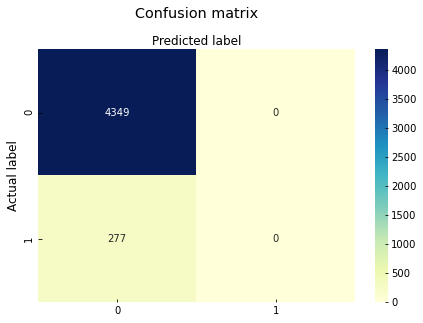

In [53]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

In [67]:
y_pred_2 = logreg.predict(x_test)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_2)
auc = metrics.roc_auc_score(y_test, y_pred_2)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

ValueError: y_true takes value in {'0', '1'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [64]:
import statsmodels.api as sm
logreg=sm.Logit(y_train, x_train)
result=logreg.fit()
print(result.summary2())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [45]:
logisticRegr.fit(x_train, y_train)


LogisticRegression()

In [49]:
# Returns a NumPy Array
# Predict for One Observation (image)
logisticRegr.predict(x_test[cols].reshape(1,-1))

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [42]:
#build logistic regression model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [55]:
#models = {"Logistic Regression": LogisticRegression(class_weight=class_weights,solver = 'liblinear'),
logmodel = LogisticRegression()

In [50]:
trainset.shape

(10794, 16)

In [98]:
import statsmodels.api as sm
logmodel=sm.Logit(y_train, x_train)
result=logmodel.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.191171
         Iterations 9
                                Results: Logit
Model:                   Logit                Pseudo R-squared:     0.156      
Dependent Variable:      FraudFound_P         AIC:                  4157.0057  
Date:                    2022-07-13 23:08     BIC:                  4266.3069  
No. Observations:        10794                Log-Likelihood:       -2063.5    
Df Model:                14                   LL-Null:              -2445.4    
Df Residuals:            10779                LLR p-value:          6.2668e-154
Converged:               1.0000               Scale:                1.0000     
No. Iterations:          9.0000                                                
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------

In [57]:
#values above p = 0.05?

In [ ]:
test_encoded = pd.get_dummies(test_set, columns=['your columns'])
test_encoded_for_model = test_encoded.reindex(columns = training_encoded.columns, 
    fill_value=0)

In [47]:
cols = ['Age', 'GDP', 'DelayInReporting', 'AccidentArea_Urban', 'Sex_Male', 'Fault_Third Party', 'BasePolicy_Collision',
         'BasePolicy_Liability', 'VehicleCategory_Sport', 'VehicleCategory_Utility', 'PastNumberOfClaims_2 to 4',
         'PastNumberOfClaims_more than 4', 'PastNumberOfClaims_none', 'PoliceReportFiled_Yes', 'WitnessPresent_Yes']

In [103]:
y_pred = logmodel.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logmodel.score(x_test, y_test)))

ValueError: shapes (10794,15) and (4626,15) not aligned: 15 (dim 1) != 4626 (dim 0)

In [100]:
y_test.shape

(4626, 1)

In [102]:
x_test.shape

(4626, 15)

x_test = x_test.tolist()
x_test = np.asfarray(x_test)
x_test.reshape(-1,1)

y_pred = logmodel.predict(x_test)
print('Accuracy of logistic regression classifier on test set:{:.2f}'.format(logmodel.score(x_test, y_test)))

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [63]:
# Let's put our models into dictionary 
models = {"Logistic Regression": LogisticRegression()}

# Let's create a function to fit and later score our models
def fit_score(models, x_train, x_test, y_train, y_test):
    """
    Fits and evaluates the given machine learning models
    """
    # random seed for reproduction
    np.random.seed(42)
    
    # Let's create a empty dictionary to keep model score
    model_score = {}
    
    # Let's loop through the models dictionary
    for name, model in models.items():
        # Fit the model
        y_pred = model.fit(x_train, y_train)
        # Evaluate the score and append it
        model_score[name] = model.score(x_test,y_test)
    return model_score, y_pred

In [64]:
model_score = fit_score(models=models,
                        x_train=x_train,
                        x_test=x_test,
                        y_train=y_train,
                        y_test=y_test)
model_score

({'Logistic Regression': 0.9401210549070471}, LogisticRegression())

In [ ]:
# Let's put our models into dictionary 
models = {"Logistic Regression": LogisticRegression()}

# Let's create a function to fit and later score our models
def fit_score(models, x_train, x_test, y_train, y_test):
    """
    Fits and evaluates the given machine learning models
    """
    # random seed for reproduction
    np.random.seed(42)
    
    # Let's create a empty dictionary to keep model score
    model_score = {}
    
    # Let's loop through the models dictionary
    for name, model in models.items():
        # Fit the model
        y_pred = model.fit(x_train, y_train)
        # Evaluate the score and append it
        model_score[name] = model.score(x_test,y_test)
    return model_score, y_pred

logmodel = LogisticRegression(random_state=7)
y_pred


In [72]:
logmodel = LogisticRegression(random_state=7)
logmodel.fit(x_train, y_train)
model_scor = logmodel.score(x_test, y_test)
model_scor

0.9401210549070471

In [73]:
y_pred = logmodel.predict(x_test)

In [74]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[4349    0]
 [ 277    0]]


In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4349
           1       0.00      0.00      0.00       277

    accuracy                           0.94      4626
   macro avg       0.47      0.50      0.48      4626
weighted avg       0.88      0.94      0.91      4626



In [77]:
from sklearn import metrics

In [65]:
from sklearn.metrics import confusion_matrix

In [75]:
import statsmodels.api as sm
logmodel=sm.Logit(y_train, x_train)
result=logmodel.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.191171
         Iterations 9
                                Results: Logit
Model:                   Logit                Pseudo R-squared:     0.156      
Dependent Variable:      FraudFound_P         AIC:                  4157.0057  
Date:                    2022-07-13 23:30     BIC:                  4266.3069  
No. Observations:        10794                Log-Likelihood:       -2063.5    
Df Model:                14                   LL-Null:              -2445.4    
Df Residuals:            10779                LLR p-value:          6.2668e-154
Converged:               1.0000               Scale:                1.0000     
No. Iterations:          9.0000                                                
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------

In [ ]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [82]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logmodel.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

ValueError: shapes (10794,15) and (4626,15) not aligned: 15 (dim 1) != 4626 (dim 0)